In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5f944509bf32b32d2eb49f46b4442b7d799d3785b2cf5df64628d8c90e7866d7
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
%tensorflow_version 2.x

In [0]:
import tarfile
import wget
import os
import re
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data


In [8]:
print('Downloading dataset...')
url = 'http://www.statmt.org/europarl/v7/fr-en.tgz'

if not os.path.exists('./fr-en.tgz'):
    wget.download(url, './fr-en.tgz')

if not (os.path.exists('./europarl-v7.fr-en.fr') and os.path.exists('./europarl-v7.fr-en.en')):
    taf = tarfile.open("./fr-en.tgz")
    taf.extractall()

In [9]:
os.listdir()

['.config',
 'europarl-v7.fr-en.en',
 'fr-en.tgz',
 'europarl-v7.fr-en.fr',
 'sample_data']

# Prepare Data

In [0]:
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text

In [0]:
def to_sentences(doc):
    return doc.strip().lower().split('\n')

In [0]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)    # pad punctuations with space on both sides 
    w = re.sub(r'[" "]+', " ", w)       # replace multiple spaces with a single space
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)      # replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = w.strip()
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def add_tokens(w):
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
def create_dataset(num_samples):
    en = to_sentences(load_doc('./europarl-v7.fr-en.en'))
    fr = to_sentences(load_doc('./europarl-v7.fr-en.fr'))

    e_sents = [preprocess_sentence(w) for w in en]
    f_sents = [preprocess_sentence(w) for w in fr]

    return e_sents[:num_samples], f_sents[:num_samples]

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [0]:
def load_dataset(num_samples):
    en, fr = create_dataset(num_samples)
    en_tensor, en_tokenizer = tokenize(en)
    fr_tensor, fr_tokenizer = tokenize(fr)
    return fr_tensor, en_tensor, fr_tokenizer, en_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(50000)

In [33]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.3)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

35000 35000 15000 15000


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 1000
units = 1000
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 201]), TensorShape([128, 173]))

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [39]:
inp_max_len, tar_max_len = max_length(input_tensor_train), max_length(target_tensor_train)
print(inp_max_len, tar_max_len)

201 173


# Model

In [0]:
def seq2seq_model():
    enc_inp = tf.keras.Input((inp_max_len))
    inp_emb = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim, mask_zero=True)(enc_inp)
    enc_lstm_1 = tf.keras.layers.LSTM(units, return_sequences=True)(inp_emb)
    enc_lstm_2 = tf.keras.layers.LSTM(units, return_sequences=True)(enc_lstm_1)
    enc_lstm_3 = tf.keras.layers.LSTM(units, return_sequences=True)(enc_lstm_2)
    enc_op, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(enc_lstm_3)

    dec_inp = tf.keras.Input((tar_max_len))
    tar_emb = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim, mask_zero=True)(dec_inp)
    #dec_lstm1 = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True)(tar_emb, initial_state=[state_h, state_c])
    #dec_lstm2 = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True)(dec_lstm1)
    #dec_lstm3 = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True)(dec_lstm2)
    dec_op = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True)(tar_emb, initial_state=[state_h, state_c])

    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_tar_size, activation='softmax'))(dec_op)
 
    model = tf.keras.Model([enc_inp, dec_inp], outputs)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 201)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 201, 1000)    23751000    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 201, 1000)    8004000     embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 201, 1000)    8004000     lstm_8[0][0]                     
____________________________________________________________________________________________

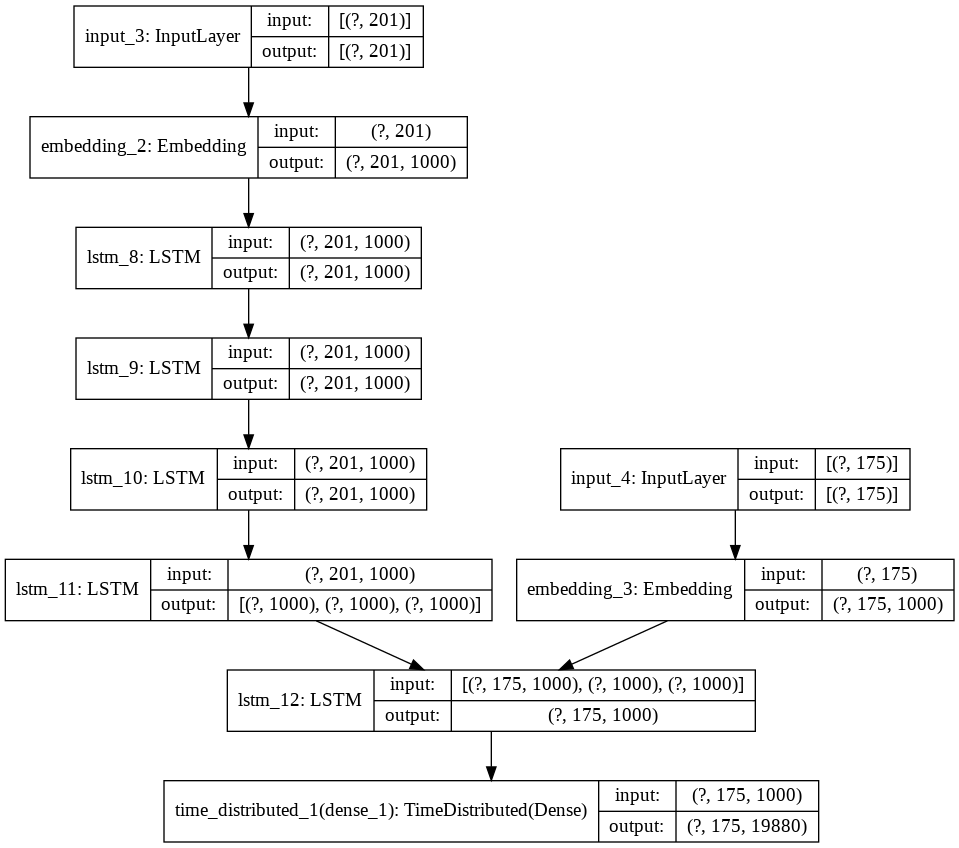

In [25]:
seq2seq = seq2seq_model()
seq2seq.summary()
tf.keras.utils.plot_model(seq2seq, to_file='seq2seq_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
seq2seq.compile(optimizer=opt, loss=loss)